In [4]:
import os
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

True

In [13]:
import uuid
import asyncio
from typing import TypedDict, List, Annotated, Optional
from dataclasses import dataclass
from IPython.display import display, Markdown
import operator

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel

# 1. 데이터 모델 정의
@dataclass
class Section:
    name: str
    description: str
    research_needed: bool
    content: str = ""

class SearchQuery(BaseModel):
    query: str
    
class SearchQueries(BaseModel):
    queries: List[SearchQuery]

class Sections(BaseModel):
    sections: List[Section]

# 2. 단순화된 상태 정의 (병렬 처리 문제 해결)
class ResearchState(TypedDict):
    topic: str
    sections: List[Section]
    current_section_index: int
    all_research_done: bool
    final_report: str

# 3. 프롬프트 템플릿
SECTION_PLANNER_PROMPT = """
주제: {topic}

위 주제에 대한 종합적인 보고서를 작성하기 위해 섹션을 계획해주세요.

다음 구조를 따르세요:
1. 소개 (연구 불필요)
2. 주요 본문 섹션들 (연구 필요)
3. 결론 (연구 불필요)

각 섹션은 다음을 포함해야 합니다:
- name: 섹션 제목
- description: 섹션 설명 (무엇을 다룰지)
- research_needed: 웹 검색이 필요한지 여부

5-6개 섹션으로 구성해주세요.
"""

QUERY_GENERATOR_PROMPT = """
주제: {topic}
섹션: {section_name}
섹션 설명: {section_description}

이 섹션을 작성하기 위해 필요한 웹 검색 쿼리 3개를 생성해주세요.
각 쿼리는 구체적이고 검색 가능한 형태여야 합니다.
"""

SECTION_WRITER_PROMPT = """
주제: {topic}
섹션 제목: {section_name}
섹션 설명: {section_description}

다음 검색 결과를 바탕으로 해당 섹션을 작성해주세요:

검색 결과:
{search_results}

요구사항:
- 마크다운 형식으로 작성
- 구체적이고 상세한 내용
- 검색 결과의 정보를 종합하여 작성
- 섹션 제목 포함 (## {section_name})
"""

# 4. 유틸리티 함수
async def search_web_tavily(queries: List[str]) -> str:
    """Tavily API를 사용한 웹 검색"""
    import os
    try:
        from tavily import TavilyClient
        
        api_key = os.getenv("TAVILY_API_KEY")
        if not api_key:
            return "Tavily API 키가 설정되지 않았습니다."
        
        client = TavilyClient(api_key=api_key)
        
        all_results = []
        for query in queries:
            try:
                response = client.search(query=query, max_results=3)
                results = response.get('results', [])
                
                for result in results:
                    content = f"제목: {result.get('title', '')}\n"
                    content += f"내용: {result.get('content', '')}\n"
                    content += f"URL: {result.get('url', '')}\n"
                    all_results.append(content)
            except Exception as e:
                print(f"검색 오류 ({query}): {e}")
                continue
        
        return "\n\n---\n\n".join(all_results)
    
    except ImportError:
        return f"검색 모의 결과: {', '.join(queries)}에 대한 검색 결과입니다."

# 5. 노드 함수들 (순차 처리 방식)
async def plan_sections(state: ResearchState) -> dict:
    """보고서 섹션 계획 생성"""
    print("📋 보고서 섹션 계획 중...")
    
    # LLM 초기화
    llm = init_chat_model(
        model="claude-3-5-haiku-latest",
        model_provider="anthropic"
    )
    
    structured_llm = llm.with_structured_output(Sections)
    
    # 프롬프트 생성
    prompt = SECTION_PLANNER_PROMPT.format(topic=state["topic"])
    
    # 섹션 생성
    response = await structured_llm.ainvoke([
        SystemMessage(content=prompt),
        HumanMessage(content="보고서 섹션을 계획해주세요.")
    ])
    
    sections = response.sections
    print(f"✅ {len(sections)}개 섹션 계획 완료")
    
    return {
        "sections": sections,
        "current_section_index": 0,
        "all_research_done": False
    }

async def process_research_sections(state: ResearchState) -> dict:
    """연구가 필요한 모든 섹션을 순차적으로 처리"""
    print("🔬 연구 섹션들 처리 시작...")
    
    sections = state["sections"]
    research_sections = [s for s in sections if s.research_needed]
    
    print(f"📊 총 {len(research_sections)}개 연구 섹션 처리 예정")
    
    # LLM 초기화 (한 번만)
    query_llm = init_chat_model(
        model="claude-3-5-haiku-latest",
        model_provider="anthropic"
    ).with_structured_output(SearchQueries)
    
    writer_llm = init_chat_model(
        model="claude-3-5-haiku-latest",
        model_provider="anthropic"
    )
    
    # 각 연구 섹션을 순차적으로 처리
    for i, section in enumerate(research_sections, 1):
        print(f"\n🔍 [{i}/{len(research_sections)}] '{section.name}' 섹션 처리 중...")
        
        try:
            # 1. 검색 쿼리 생성
            query_prompt = QUERY_GENERATOR_PROMPT.format(
                topic=state["topic"],
                section_name=section.name,
                section_description=section.description
            )
            
            query_response = await query_llm.ainvoke([
                SystemMessage(content=query_prompt),
                HumanMessage(content="검색 쿼리를 생성해주세요.")
            ])
            
            queries = [q.query for q in query_response.queries]
            print(f"  📝 {len(queries)}개 검색 쿼리 생성 완료")
            
            # 2. 웹 검색
            print(f"  🌐 웹 검색 실행 중...")
            search_results = await search_web_tavily(queries)
            print(f"  ✅ 검색 완료 ({len(search_results)} 문자)")
            
            # 3. 섹션 작성
            print(f"  ✍️ 섹션 내용 작성 중...")
            writer_prompt = SECTION_WRITER_PROMPT.format(
                topic=state["topic"],
                section_name=section.name,
                section_description=section.description,
                search_results=search_results
            )
            
            writer_response = await writer_llm.ainvoke([
                SystemMessage(content=writer_prompt),
                HumanMessage(content="섹션을 작성해주세요.")
            ])
            
            # 섹션 내용 업데이트
            section.content = writer_response.content
            print(f"  ✅ '{section.name}' 섹션 완료!")
            
        except Exception as e:
            print(f"  ❌ '{section.name}' 섹션 처리 중 오류: {e}")
            section.content = f"## {section.name}\n\n{section.description}\n\n(처리 중 오류가 발생했습니다: {e})"
    
    print(f"\n🎉 모든 연구 섹션 처리 완료!")
    return {
        "sections": sections,
        "all_research_done": True
    }

async def write_non_research_sections(state: ResearchState) -> dict:
    """연구가 필요하지 않은 섹션들 작성"""
    print("📝 소개/결론 섹션 작성 중...")
    
    sections = state["sections"]
    
    for section in sections:
        if not section.research_needed and not section.content:
            # 연구가 필요하지 않은 섹션은 간단히 작성
            if "소개" in section.name.lower() or "introduction" in section.name.lower():
                content = f"""## {section.name}

{section.description}

이 보고서는 {state['topic']}에 대한 종합적인 분석을 제공합니다."""
            else:  # 결론
                content = f"""## {section.name}

{section.description}

이상으로 {state['topic']}에 대한 분석을 마칩니다."""
            
            section.content = content
            print(f"✅ '{section.name}' 섹션 작성 완료")
    
    return {"sections": sections}

async def compile_final_report(state: ResearchState) -> dict:
    """최종 보고서 컴파일"""
    print("📊 최종 보고서 컴파일 중...")
    
    sections = state["sections"]
    
    # 섹션 내용 합치기
    sections_content = []
    for section in sections:
        if section.content:
            sections_content.append(section.content)
        else:
            # 빈 섹션이 있다면 기본 내용 추가
            sections_content.append(f"## {section.name}\n\n{section.description}")
    
    # 최종 보고서 생성
    final_report = "\n\n".join(sections_content)
    
    print("✅ 최종 보고서 컴파일 완료")
    return {"final_report": final_report}

# 6. 조건부 라우팅 함수
def should_continue_research(state: ResearchState) -> str:
    """연구가 완료되었는지 확인"""
    if state.get("all_research_done", False):
        return "write_non_research"
    else:
        return "process_research"

# 7. 단순화된 그래프 생성
def create_research_agent():
    """단순화된 자동 연구 에이전트 생성"""
    
    # 메인 그래프 (순차 처리)
    main_graph = StateGraph(ResearchState)
    
    main_graph.add_node("plan_sections", plan_sections)
    main_graph.add_node("process_research", process_research_sections)
    main_graph.add_node("write_non_research", write_non_research_sections)
    main_graph.add_node("compile_report", compile_final_report)
    
    # 엣지 연결 (순차적)
    main_graph.add_edge(START, "plan_sections")
    main_graph.add_conditional_edges(
        "plan_sections",
        should_continue_research,
        {
            "process_research": "process_research",
            "write_non_research": "write_non_research"
        }
    )
    main_graph.add_edge("process_research", "write_non_research")
    main_graph.add_edge("write_non_research", "compile_report")
    main_graph.add_edge("compile_report", END)
    
    return main_graph.compile(checkpointer=MemorySaver())

def visualize_graph(show_xray=True):
    """그래프 구조 시각화"""
    print("📊 그래프 구조 시각화 중...")
    
    try:
        # 그래프 생성
        graph = create_research_agent()
        
        # 그래프 이미지 생성
        if show_xray:
            # X-ray 모드: 서브그래프까지 자세히 보기
            graph_image = graph.get_graph(xray=1).draw_mermaid_png()
        else:
            # 기본 모드: 메인 노드만 보기
            graph_image = graph.get_graph().draw_mermaid_png()
        
        # 이미지 표시
        from IPython.display import Image, display
        display(Image(graph_image))
        
        print("✅ 그래프 시각화 완료!")
        
        return graph_image
        
    except Exception as e:
        print(f"❌ 그래프 시각화 실패: {e}")
        print("Mermaid 또는 graphviz 패키지가 필요할 수 있습니다.")
        return None

# 8. 사용 함수
async def run_research_agent(topic: str, display_result: bool = True):
    """연구 에이전트 실행"""
    print(f"🚀 연구 시작: {topic}")
    print("=" * 80)
    
    # 그래프 생성
    graph = create_research_agent()
    
    # 실행 설정
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    # 초기 상태
    initial_state = {
        "topic": topic,
        "sections": [],
        "current_section_index": 0,
        "all_research_done": False,
        "final_report": ""
    }
    
    # 실행
    try:
        final_state = await graph.ainvoke(initial_state, config)
        
        print("=" * 80)
        print("🎉 연구 완료!")
        
        if display_result and final_state.get("final_report"):
            print("\n📄 최종 보고서:")
            print("-" * 40)
            display(Markdown(final_state["final_report"]))
        
        return final_state["final_report"]
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        return None

# 9. 사용 예제
if __name__ == "__main__":
    # 사용 예제
    topic = "Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs"
    
    print("사용법:")
    print("# 그래프 구조 보기")
    print("visualize_graph()")
    print("\n# 연구 실행")
    print("await run_research_agent(topic)")
    print("\n# 수동 실행")
    print("graph = create_research_agent()")
    print("result = await graph.ainvoke({'topic': topic, 'sections': [], 'current_section_index': 0, 'all_research_done': False, 'final_report': ''})")

# 즉시 그래프 시각화 (선택사항)
def show_graph_now():
    """지금 즉시 그래프 보기"""
    print("🎨 그래프 구조 미리보기:")
    return visualize_graph(show_xray=False)

사용법:
# 그래프 구조 보기
visualize_graph()

# 연구 실행
await run_research_agent(topic)

# 수동 실행
graph = create_research_agent()
result = await graph.ainvoke({'topic': topic, 'sections': [], 'current_section_index': 0, 'all_research_done': False, 'final_report': ''})


🎨 그래프 구조 미리보기:
📊 그래프 구조 시각화 중...


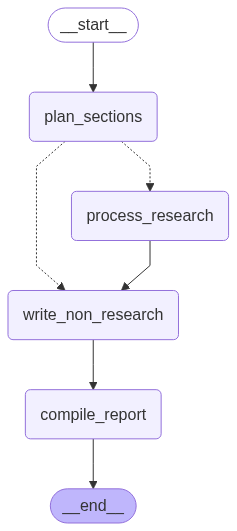

✅ 그래프 시각화 완료!


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xed\x00\x00\x02\x13\x08\x02\x00\x00\x00d(\x0c\x98\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00 \x00IDATx\x9c\xed\xddw\\\x13\xf7\xff\x07\xf0O\xf6\x82$\xec\xbd\xb7\x8a\xa2 \x8eVQAp\xa0\x15\xf7\xc0\xf9u[\xebB\xeb\xde\xabV\xadU\xab\xad{\xd5\xa2\xd6\xbd\xb7V\xdc\x8b\xe9D\xa6  +{\x90\xf1\xfb\xe3\xfc!U@\xb0I.9\xde\xcf\x87\x0f\x1f\xc9\xe5r\x9fw\xc2+\x97w.w\x17\x92V\xabE\x00\x9882\xde\x05\x00\xa0\x03\x90c@\x04\x90c@\x04\x90c@\x04\x90c@\x04\x90c@\x04T\xbc\x0b\xf8Jr\xa9\xa6\xe4\x9dB"PI\x85j\x95J\xab\xae0\x81\xad\x87t\x16\x99\xce$s\xb8T\x0e\x8fj\xe3D\xc7\xbb\x1cB1\xb1\x1c\x8b\xca\xd5\xaf\x9f\n3S%\n\xa9\x86iF\xe1p)\x1c.\xd5\x8cO\xd5jL \xc7\x08\xa1\xc2l\xb9D\xa8b\xb0)\xb9/\xa5\x1e\x8d9^M\xcd\xdc\x02\xd8x\x17E\x04$S\xf9\x1e\xa4B\xa1\xbds\xa6XXZaiO\xf7ll\xe6\xe0\xc9\xc4\xbb\xa2\xffD&Vg\xa4J\n\xb2d\x05\xd9\x8a\xb6\xd1V\x1e\x8d9xWd\xdaL#\xc7\xc9\xb7\x04w\xcf\x16\xb7\x8d\xb6\x0e\xfc\x96\x87w-:VZ\xa0\xbcs\xb6\x84B!E\r\xb5\'S\xf0\xae\xc6d\x99@\x8e/\xffYh

In [14]:
show_graph_now()

In [10]:
# 그래프 생성
graph = create_research_agent()

# 초기 상태
initial_state = {
    "topic": topic,
    "sections": [],
    "completed_sections": [],
    "current_section_index": 0,
    "final_report": ""
}

# 실행
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = await graph.ainvoke(initial_state, config)

# 결과 확인
display(Markdown(result["final_report"]))

📋 보고서 섹션 계획 중...
✅ 6개 섹션 계획 완료
🔬 연구 섹션들 처리 시작...
📊 총 4개 연구 섹션 처리 예정

🔍 [1/4] 'Technical Architecture of MCP' 섹션 처리 중...
  📝 3개 검색 쿼리 생성 완료
  🌐 웹 검색 실행 중...
  ✅ 검색 완료 (19091 문자)
  ✍️ 섹션 내용 작성 중...
  ✅ 'Technical Architecture of MCP' 섹션 완료!

🔍 [2/4] 'Context Integration Mechanisms' 섹션 처리 중...
  📝 3개 검색 쿼리 생성 완료
  🌐 웹 검색 실행 중...
  ✅ 검색 완료 (9909 문자)
  ✍️ 섹션 내용 작성 중...
  ✅ 'Context Integration Mechanisms' 섹션 완료!

🔍 [3/4] 'Potential Applications and Use Cases' 섹션 처리 중...
  📝 3개 검색 쿼리 생성 완료
  🌐 웹 검색 실행 중...
  ✅ 검색 완료 (7857 문자)
  ✍️ 섹션 내용 작성 중...
  ✅ 'Potential Applications and Use Cases' 섹션 완료!

🔍 [4/4] 'Comparative Analysis with Existing Protocols' 섹션 처리 중...
  📝 3개 검색 쿼리 생성 완료
  🌐 웹 검색 실행 중...
  ✅ 검색 완료 (8688 문자)
  ✍️ 섹션 내용 작성 중...
  ✅ 'Comparative Analysis with Existing Protocols' 섹션 완료!

🎉 모든 연구 섹션 처리 완료!
📝 소개/결론 섹션 작성 중...
✅ 'Introduction to Model Context Protocol (MCP)' 섹션 작성 완료
✅ 'Conclusion and Future Outlook' 섹션 작성 완료
📊 최종 보고서 컴파일 중...
✅ 최종 보고서 컴파일 완료


## Introduction to Model Context Protocol (MCP)

배경, 개발 목적, 및 Anthropic의 역할 소개

이 보고서는 Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs에 대한 종합적인 분석을 제공합니다.

## Technical Architecture of MCP

Model Context Protocol (MCP)은 대규모 언어 모델(LLM)과 외부 도구 및 데이터 소스 간의 통합을 위한 혁신적인 오픈 표준 프로토콜입니다. MCP의 기술 아키텍처는 다음과 같은 핵심 구성 요소와 원칙으로 설계되었습니다:

### 1. 클라이언트-서버 아키텍처

MCP는 기본적으로 클라이언트-서버 모델을 기반으로 합니다:
- **MCP 서버**: 외부 데이터 소스, 도구, API를 노출하는 엔드포인트
- **MCP 클라이언트**: AI 모델의 요청을 서버로 전달하는 중개 서비스

### 2. 프로토콜 계층 구조

#### 프로토콜 계층
- 메시지 프레이밍 처리
- 요청/응답 연결 관리
- 고수준 통신 패턴 정의

#### 전송 계층
- 클라이언트와 서버 간 실제 통신 처리
- 통신 방식:
  - 서버→클라이언트: Server-Sent Events (SSE)
  - 클라이언트→서버: HTTP POST
- JSON-RPC 2.0 메시지 교환 표준 준수

### 3. 주요 통신 흐름

1. 클라이언트가 `initialize` 요청 전송
   - 프로토콜 버전
   - 지원 가능한 기능 명시

2. 서버-클라이언트 간 양방향 메시지 교환
   - 요청/응답 메커니즘
   - 오류 처리 및 이벤트 관리

### 4. 보안 및 기능 표준화

- 보안된 연결 지원
- 표준화된 인터페이스로 M x N 통합 복잡성 감소
- 다양한 AI 애플리케이션과 도구 간 일관된 통신 방식 제공

### 5. 기본 primitives

MCP 서버는 다음 핵심 기본 요소를 제공:
- **Prompts**: 컨텍스트 제공
- **Resources**: 데이터 액세스
- **Tools**: 외부 기능 호출

### 구현 예시

```python
# 기본 MCP 서버 연결 예시
await server.connect(transport)
# 오류 처리 및 리소스 정리 포함
```

### 주요 장점

- 표준화된 AI 도구 통합
- 유연한 컨텍스트 교환
- 보안성 높은 프로토콜
- 다양한 데이터 소스와의 쉬운 연결

MCP는 AI 애플리케이션의 외부 시스템 연결을 혁신적으로 단순화하고 표준화하는 핵심 프로토콜입니다.

## Context Integration Mechanisms

Model Context Protocol (MCP)은 대규모 언어 모델(LLM)과 외부 도구, 시스템, 데이터 소스 간의 컨텍스트 통합을 혁신적으로 개선하는 메커니즘을 제공합니다.

### MCP의 핵심 통합 메커니즘

1. **양방향 데이터 연결**
   - 개발자들이 안전하고 효율적인 두 방향 데이터 연결을 구축할 수 있음
   - MCP 서버를 통해 데이터 소스 노출 가능
   - AI 애플리케이션(MCP 클라이언트)을 서버에 연결 가능

2. **표준화된 통합 아키텍처**
   - M x N 통합 복잡성을 M + N 문제로 단순화
   - 다양한 AI 애플리케이션과 도구/데이터 소스 간 일관된 통신 프로토콜 제공
   - 유지보수성과 확장성 향상

3. **유연한 컨텍스트 서버 구현**
   - 맞춤형 MCP 서버 생성 지원
   - 독점 시스템이나 특수 데이터 소스를 AI 모델에 연결 가능
   - Claude 3.5 Sonnet과 같은 모델이 신속한 서버 구현 지원

### 주요 통합 방식

- **로컬 MCP 서버**: 내부 시스템 및 데이터셋에 직접 연결
- **원격 MCP 서버**: 외부 데이터 소스와의 안전한 통신
- **AI 도구 연결**: 코드 실행, 스프레드시트 통합 등 다양한 도구 지원

### 기대 효과

- 컨텍스트 접근성 향상
- AI 모델의 실시간 데이터 활용 능력 증대
- 개발자의 AI 통합 복잡성 감소
- 표준화된 AI 에이전트 에코시스템 구축

MCP는 AI 모델이 외부 컨텍스트와 상호작용하는 방식을 근본적으로 변화시키는 혁신적인 프로토콜로 평가받고 있습니다.

## Potential Applications and Use Cases

Model Context Protocol (MCP)는 다양한 산업 및 기술 분야에서 혁신적인 응용 사례를 제공합니다:

### 1. 엔터프라이즈 AI 통합
- 기업 데이터 시스템과 AI 모델 간 원활한 연결
- 운영 효율성 5-10% 개선 예상
- 실시간 비즈니스 데이터와 AI 모델의 직접적인 상호작용 지원

### 2. 클라우드 서비스 통합
#### 주요 클라우드 플랫폼 적용 사례
- Microsoft Azure: OpenAI 서비스와 MCP 통합
- Amazon SageMaker: AI 모델 확장 및 외부 도구 연결
- AWS: 서버리스 환경에서 MCP 서버 배포

### 3. 개발자 도구 및 에이전트 빌딩
- AI 에이전트 개발을 위한 표준화된 프레임워크
- 외부 도구 및 API와의 효율적인 상호작용
- 다양한 AI 백엔드 지원 (Claude, GPT 등)

### 4. 데이터 접근 및 도구 통합
#### 주요 특징
- 로컬/원격 리소스 연결 (파일, 데이터베이스, 웹 API)
- 보안된 도구 사용 권한 관리
- 실시간 데이터 페칭 및 처리

### 5. 산업별 응용 분야
- 금융: 실시간 시장 데이터 분석
- 의료: 환자 데이터와 AI 진단 통합
- 교육: 맞춤형 학습 리소스 제공
- 연구: 대규모 데이터셋과 AI 모델 연결

### 6. 미래 전망
- 주요 기술 기업들의 적극적인 채택 (Google DeepMind, OpenAI)
- AI 에이전트 시대를 위한 개방형 표준으로 발전 중
- 기업의 AI 투자 ROI 향상 기대

MCP는 AI 모델과 외부 컨텍스트 간의 통합을 혁신적으로 개선하여, 다양한 산업 분야에서 AI의 실용성과 효율성을 크게 높일 것으로 전망됩니다.

## Comparative Analysis with Existing Protocols

Model Context Protocol (MCP)은 기존의 AI 통합 프레임워크와 차별화된 몇 가지 중요한 특징을 가지고 있습니다:

### 1. LangChain과의 주요 차이점

#### 아키텍처 접근 방식
- **LangChain**: 복잡한 AI 워크플로우와 에이전트 체이닝에 중점
- **MCP**: 표준화된 데이터 통합과 도구 연결에 초점

#### 통합 철학
- **LangChain**: 유연하고 프로그래밍 중심의 통합 방식
- **MCP**: 개방형 표준과 간소화된 연결 메커니즘 제공

### 2. 기술적 차별점

#### 연결 모델
- **통합 방식**: MCP는 "유니버설 어댑터" 개념으로 모든 AI 에이전트가 동일한 생태계에 쉽게 접근 가능
- **서버 구현**: 개발자가 맞춤형 MCP 서버를 통해 독점 시스템이나 특수 데이터 소스 연결 가능

### 3. 주요 장점

1. **표준화된 프로토콜**
   - 데이터 소스와 AI 도구 간 안전하고 양방향 연결 지원
   - 일관된 인터페이스로 복잡성 감소

2. **유연성**
   - 조직과 개인이 중요한 데이터셋을 다양한 AI 도구와 신속하게 연결 가능
   - Claude 3.5 Sonnet과 같은 모델의 MCP 서버 구현 용이성

### 4. 업계 채택 전망

- Google DeepMind의 Demis Hassabis는 MCP를 "AI 에이전트 시대를 위한 개방형 표준"으로 평가
- Gemini 모델에서의 MCP 지원 예정

### 결론

MCP는 단순한 통합 프로토콜을 넘어, AI 모델과 외부 컨텍스트 간의 상호작용을 혁신적으로 재정의하는 접근 방식을 제시합니다.

## Conclusion and Future Outlook

MCP의 전망, 예상되는 발전 방향 및 요약

이상으로 Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs에 대한 분석을 마칩니다.

In [11]:
result["final_report"]

'## Introduction to Model Context Protocol (MCP)\n\n배경, 개발 목적, 및 Anthropic의 역할 소개\n\n이 보고서는 Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs에 대한 종합적인 분석을 제공합니다.\n\n## Technical Architecture of MCP\n\nModel Context Protocol (MCP)은 대규모 언어 모델(LLM)과 외부 도구 및 데이터 소스 간의 통합을 위한 혁신적인 오픈 표준 프로토콜입니다. MCP의 기술 아키텍처는 다음과 같은 핵심 구성 요소와 원칙으로 설계되었습니다:\n\n### 1. 클라이언트-서버 아키텍처\n\nMCP는 기본적으로 클라이언트-서버 모델을 기반으로 합니다:\n- **MCP 서버**: 외부 데이터 소스, 도구, API를 노출하는 엔드포인트\n- **MCP 클라이언트**: AI 모델의 요청을 서버로 전달하는 중개 서비스\n\n### 2. 프로토콜 계층 구조\n\n#### 프로토콜 계층\n- 메시지 프레이밍 처리\n- 요청/응답 연결 관리\n- 고수준 통신 패턴 정의\n\n#### 전송 계층\n- 클라이언트와 서버 간 실제 통신 처리\n- 통신 방식:\n  - 서버→클라이언트: Server-Sent Events (SSE)\n  - 클라이언트→서버: HTTP POST\n- JSON-RPC 2.0 메시지 교환 표준 준수\n\n### 3. 주요 통신 흐름\n\n1. 클라이언트가 `initialize` 요청 전송\n   - 프로토콜 버전\n   - 지원 가능한 기능 명시\n\n2. 서버-클라이언트 간 양방향 메시지 교환\n   - 요청/응답 메커니즘\n   - 오류 처리 및 이벤트 관리\n\n### 4. 보안 및 기능 표준화\n\n- 보안된 연결 지원\n- 표준화된 인터페이스로 M x N